In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from matplotlib import cm
from sklearn import mixture
from matplotlib import dates
from sklearn import preprocessing
from arch.univariate import arch_model

In [2]:
import ruptures as rpt
from hmmlearn import hmm

In [3]:
sns.set()
sns.mpl.rcParams['figure.figsize'] = (25.0, 10.0)
sns.mpl.rcParams['savefig.dpi'] = 90
sns.mpl.rcParams['font.family'] = 'sans-serif'
sns.mpl.rcParams['font.size'] = 14

In [4]:
df_data = pd.read_csv(r'/home/brainiac/Vlad/Jupyter Notebooks/DataSets/Market Regimes/Input/VLADISLAV_t1000_selected_features.csv')

In [5]:
df_data.head(3)

,"p_25_value__fft_coefficient__coeff_0__attr_""abs""",volatility_bbw,p_55_value__quantile__q_0.7,close,p_25_value__maximum,trend_macd,"p_55_value__fft_coefficient__coeff_0__attr_""abs""",datetime,momentum_roc,"p_75_value__fft_coefficient__coeff_0__attr_""abs""",...,momentum_rsi_p_20,p_25_value__minimum,"p_35_value__fft_coefficient__coeff_0__attr_""abs""",p_45_value__sum_values,p_15_value__quantile__q_0.1,"p_5_value__fft_coefficient__coeff_0__attr_""abs""",p_85_value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,p_95_value__absolute_sum_of_changes,"p_65_value__fft_coefficient__coeff_0__attr_""abs""",volatility_bbh
0,0.000017,5.249339,0.000017,3691.5,0.000017,0.270111,0.000017,2019-01-01 00:32:53.598027,0.0,0.000017,...,100.000000,0.000017,0.000017,0.000017,0.000017,0.000017,0.0,0.000000,0.000017,3692.291336
1,0.000099,13.490738,0.000063,3697.0,0.000082,0.886156,0.000099,2019-01-01 00:33:51.189501,0.0,0.000099,...,100.000000,0.000017,0.000099,0.000099,0.000023,0.000099,0.0,0.000066,0.000099,3698.245369
2,0.000280,12.986146,0.000122,3694.5,0.000181,1.159283,0.000280,2019-01-01 00:42:49.305723,0.0,0.000280,...,75.984486,0.000017,0.000280,0.000280,0.000030,0.000280,0.0,0.000165,0.000280,3698.593073


In [6]:
df_data = df_data.dropna()

In [7]:
df_data.shape

(243919, 28)

# Прогнозирование волатильности EGARCH

In [8]:
# Для вычисления волатильности EGARCH необходимо рассчитать возвраты. В данном блоке есть два блока рассчета волатильности. 
# Скорее всего, более правильный второй. В нем добавляются возвраты.

In [9]:
# Вычисление возвратов
returns = 100*df_data['close'].pct_change()

##### Первый вариант

In [10]:
# %%time
# egarch_train_part=110_000 #  начальные объем данных для обучения 
# egarch_forec_part=10_000 # объем данных для выполнения прогноза волатильности

# egarch_vol=[] # список значений спрогнозированной волатильности
# egarch_vol=returns.iloc[0:110_000].dropna() # вычисляем возвраты для обучения модели
# egarch_vol_list=list(egarch_vol)

# for i in range(1, math.ceil((len(df_data)-egarch_train_part)/egarch_forec_part)+1):
#     egarch_model = arch_model(egarch_vol, vol='EGARCH', p=5, q=1, dist='studentst', mean='ARX', rescale=False) 
#     results = egarch_model.fit(last_obs=100_000, update_freq=10) # обучаем модель на 100 тысячах наблюдений
#     forecasts = results.forecast(horizon=1, start=100_000, method='simulation') # прогнозируем волатильность на ближайшие 10 тысяч наблюдений
#     egarch_vol_list.extend(np.sqrt(forecasts.variance.dropna()['h.1'].values)) # записываем результаты рассчитанной волатильности

##### Второй вариант

In [11]:
%%time
egarch_part=10_000 # данные для модели EGARCH 
egarch_train=9_000 # данные для обучения
egarch_forec=1_000 # данные для прогноза
egarch_vol = [] # список для волатильности
egarch_vol.extend(abs(df_data['close'][0:egarch_train+1].pct_change().rolling(5).std()*100)) # первые несколько измерений заменяются простым std

for i in range(1, math.ceil((len(df_data)-egarch_train)/egarch_forec)+1):
    egarch_model = arch_model(returns.iloc[(i-1)*egarch_forec:egarch_part+egarch_forec*(i-1)].dropna(), vol='EGARCH', p=5, q=1, dist='studentst', mean='ARX', rescale=False)
    results = egarch_model.fit(last_obs=egarch_part-egarch_forec, update_freq=10) # обучение модели
    forecasts = results.forecast(horizon=1, start=egarch_part-egarch_forec, method='simulation') # прогнозирование волатильности
    egarch_vol.extend(np.sqrt(forecasts.variance.dropna()['h.1'].values)) # формирование списка волатильностей

Iteration:     10,   Func. Count:    147,   Neg. LLF: -6863.315116776027
Iteration:     20,   Func. Count:    260,   Neg. LLF: -6983.755175925362
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6983.83604085184
            Iterations: 25
            Function evaluations: 315
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    148,   Neg. LLF: -7211.167963236429
Iteration:     20,   Func. Count:    260,   Neg. LLF: -7245.5665652605285
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7245.579853666321
            Iterations: 24
            Function evaluations: 304
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -7558.05278723905
Iteration:     20,   Func. Count:    259,   Neg. LLF: -7577.1924086547
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7577.192410241339
            Iterations: 21
            Function evaluations: 270
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -8018.592066157226
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8041.222147400133
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8041.222163335146
            Iterations: 22
            Function evaluations: 281
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -8240.070288963854
Iteration:     20,   Func. Count:    256,   Neg. LLF: -8272.562360219825
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8272.563030035797
            Iterations: 23
            Function evaluations: 300
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8771.36025694781
Iteration:     20,   Func. Count:    257,   Neg. LLF: -8788.347441105097
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8788.351556303674
            Iterations: 25
            Function evaluations: 318
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -8932.27105589651
Iteration:     20,   Func. Count:    257,   Neg. LLF: -8967.226648867663
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8967.226667702347
            Iterations: 22
            Function evaluations: 283
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8781.343606421735
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8813.463285624326
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8813.463330092412
            Iterations: 22
            Function evaluations: 287
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -8976.32562403616
Iteration:     20,   Func. Count:    256,   Neg. LLF: -9012.665989328209
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9012.6727048686
            Iterations: 23
            Function evaluations: 300
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8636.847737893857
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8675.100133646647
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8675.100257500415
            Iterations: 24
            Function evaluations: 311
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -8683.411608062066
Iteration:     20,   Func. Count:    256,   Neg. LLF: -8721.669865548352
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8721.670109540584
            Iterations: 22
            Function evaluations: 289
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -8571.225111408148
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8638.606739569283
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8639.314971731907
            Iterations: 25
            Function evaluations: 325
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8260.972723189077
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8329.45475064413
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8330.211077209373
            Iterations: 27
            Function evaluations: 349
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8346.6917840536
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8389.570138975965
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8389.58202468818
            Iterations: 25
            Function evaluations: 317
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8311.659383824852
Iteration:     20,   Func. Count:    257,   Neg. LLF: -8361.696036497913
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8361.696344126167
            Iterations: 24
            Function evaluations: 315
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -8461.429563541298
Iteration:     20,   Func. Count:    260,   Neg. LLF: -8518.093295625491
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8519.157752023273
            Iterations: 26
            Function evaluations: 340
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -8943.886556551694
Iteration:     20,   Func. Count:    261,   Neg. LLF: -8997.40793284451
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8997.882910190277
            Iterations: 27
            Function evaluations: 352
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -9189.465307182003
Iteration:     20,   Func. Count:    260,   Neg. LLF: -9259.406824647227
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9259.817376927142
            Iterations: 24
            Function evaluations: 316
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -9811.005229147306
Iteration:     20,   Func. Count:    258,   Neg. LLF: -9861.80308185146
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9861.843393590869
            Iterations: 26
            Function evaluations: 331
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -10018.900832408377
Iteration:     20,   Func. Count:    258,   Neg. LLF: -10067.599218609512
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10067.636544317755
            Iterations: 26
            Function evaluations: 329
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -9240.339057726987
Iteration:     20,   Func. Count:    260,   Neg. LLF: -9291.504153233796
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9291.53674495169
            Iterations: 24
            Function evaluations: 316
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -8632.156081853727
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8698.195778415293
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8698.29268918148
            Iterations: 24
            Function evaluations: 315
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -8113.604557818589
Iteration:     20,   Func. Count:    261,   Neg. LLF: -8182.751468782617
Iteration:     30,   Func. Count:    374,   Neg. LLF: -8183.508355899121
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8183.508355897135
            Iterations: 30
            Function evaluations: 385
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    148,   Neg. LLF: -7455.317177414851
Iteration:     20,   Func. Count:    263,   Neg. LLF: -7531.110482045355
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7532.322466581098
            Iterations: 25
            Function evaluations: 329
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -6993.145869125328
Iteration:     20,   Func. Count:    259,   Neg. LLF: -7057.294530889283
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7057.452878614041
            Iterations: 24
            Function evaluations: 314
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6325.435693346536
Iteration:     20,   Func. Count:    257,   Neg. LLF: -6388.0877951390485
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6389.197138750566
            Iterations: 24
            Function evaluations: 312
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -5801.891993162716
Iteration:     20,   Func. Count:    258,   Neg. LLF: -5858.382481993844
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5858.676598932003
            Iterations: 27
            Function evaluations: 353
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5428.5095658087685
Iteration:     20,   Func. Count:    259,   Neg. LLF: -5477.119322475102
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5477.126094593575
            Iterations: 22
            Function evaluations: 292
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -5181.056860767349
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5232.953114876336
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5232.957545056568
            Iterations: 23
            Function evaluations: 299
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5810.334552833061
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5903.66404338539
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5904.762750932411
            Iterations: 25
            Function evaluations: 322
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6248.1792303014045
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6326.555323184099
Iteration:     30,   Func. Count:    373,   Neg. LLF: -6326.625365621305
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6326.6253656213485
            Iterations: 30
            Function evaluations: 384
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6493.775213474883
Iteration:     20,   Func. Count:    256,   Neg. LLF: -6585.401695336718
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6585.47250322733
            Iterations: 25
            Function evaluations: 317
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6951.4741704560265
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7030.522747235803
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7030.55050256197
            Iterations: 23
            Function evaluations: 298
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7339.01503111697
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7404.251612956243
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7404.260960378395
            Iterations: 22
            Function evaluations: 281
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7582.33034136
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7641.628985389426
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7641.634522763787
            Iterations: 24
            Function evaluations: 298
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7608.2796028760185
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7659.596975602507
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7659.598008938075
            Iterations: 24
            Function evaluations: 301
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -7568.119852537711
Iteration:     20,   Func. Count:    256,   Neg. LLF: -7628.261029275681
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7628.264759578854
            Iterations: 24
            Function evaluations: 311
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -7381.789396581877
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7432.710493657625
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7432.711544476103
            Iterations: 22
            Function evaluations: 281
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -7205.221233301981
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7277.307549515155
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7277.307751095496
            Iterations: 22
            Function evaluations: 280
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7355.011749945026
Iteration:     20,   Func. Count:    258,   Neg. LLF: -7437.282617632782
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7437.633956040747
            Iterations: 26
            Function evaluations: 327
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7146.489299204177
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7246.10702188415
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7246.1218214798255
            Iterations: 23
            Function evaluations: 301
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -6568.51100925581
Iteration:     20,   Func. Count:    262,   Neg. LLF: -6642.213970362382
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6644.759157891652
            Iterations: 25
            Function evaluations: 319
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5782.736836882634
Iteration:     20,   Func. Count:    256,   Neg. LLF: -5817.548170524031
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5817.548279142952
            Iterations: 21
            Function evaluations: 269
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -5346.4912230358
Iteration:     20,   Func. Count:    256,   Neg. LLF: -5378.588234374604
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5378.588282202485
            Iterations: 21
            Function evaluations: 278
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4728.6635910331315
Iteration:     20,   Func. Count:    256,   Neg. LLF: -4761.157431637492
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4761.15745895968
            Iterations: 23
            Function evaluations: 293
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4023.535160255773
Iteration:     20,   Func. Count:    257,   Neg. LLF: -4047.6682088161606
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4047.668237038425
            Iterations: 22
            Function evaluations: 291
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -3755.2770367426274
Iteration:     20,   Func. Count:    258,   Neg. LLF: -3766.633220189202
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3766.6332203520037
            Iterations: 20
            Function evaluations: 269
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -3302.3536559328472
Iteration:     20,   Func. Count:    256,   Neg. LLF: -3318.022336954413
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3318.1485014937284
            Iterations: 22
            Function evaluations: 289
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -2504.35928761781
Iteration:     20,   Func. Count:    255,   Neg. LLF: -2521.6711851445416
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2521.6711851439777
            Iterations: 20
            Function evaluations: 266
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2299.224887346884
Iteration:     20,   Func. Count:    254,   Neg. LLF: -2314.973965502387
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2314.9770516602125
            Iterations: 23
            Function evaluations: 300
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -2421.6319703547833
Iteration:     20,   Func. Count:    255,   Neg. LLF: -2446.931620398529
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2446.9316204055062
            Iterations: 20
            Function evaluations: 266
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2577.42984176479
Iteration:     20,   Func. Count:    253,   Neg. LLF: -2612.104502528817
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2612.1976536988095
            Iterations: 25
            Function evaluations: 323
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2647.825673417034
Iteration:     20,   Func. Count:    254,   Neg. LLF: -2675.774708078691
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2676.0003596474635
            Iterations: 26
            Function evaluations: 344
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -3118.3317647260164
Iteration:     20,   Func. Count:    254,   Neg. LLF: -3151.565892688817
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3151.747464812158
            Iterations: 27
            Function evaluations: 345
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -3532.0488128689294
Iteration:     20,   Func. Count:    254,   Neg. LLF: -3570.4065559505243
Iteration:     30,   Func. Count:    372,   Neg. LLF: -3570.5766437603397
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3570.5766518266973
            Iterations: 31
            Function evaluations: 398
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -3906.0275572056457
Iteration:     20,   Func. Count:    255,   Neg. LLF: -3942.5433417514723
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3943.9725260449054
            Iterations: 27
            Function evaluations: 356
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4391.411499976464
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4441.001648696389
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4441.94742059517
            Iterations: 28
            Function evaluations: 361
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -4876.32084465779
Iteration:     20,   Func. Count:    252,   Neg. LLF: -4921.984708736663
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4922.71034891448
            Iterations: 26
            Function evaluations: 340
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -5227.056123671682
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5267.7799385182725
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5268.426448908751
            Iterations: 27
            Function evaluations: 355
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5535.103292121366
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5579.299705987058
            Iterations: 19
            Function evaluations: 254
            Gradient evaluations: 19


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -5708.818242120121
Iteration:     20,   Func. Count:    253,   Neg. LLF: -5764.986269429375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5766.76523356689
            Iterations: 26
            Function evaluations: 320
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6114.8890433939105
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6174.845542220107
Iteration:     30,   Func. Count:    379,   Neg. LLF: -6174.906780532712
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6174.907092211169
            Iterations: 37
            Function evaluations: 473
            Gradient evaluations: 37


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6299.740750615379
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6350.586344437912
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6350.711606091087
            Iterations: 26
            Function evaluations: 344
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -6238.761412777217
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6284.266382345648
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6285.159980452348
            Iterations: 29
            Function evaluations: 379
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5910.061546632773
Iteration:     20,   Func. Count:    252,   Neg. LLF: -5954.463159687131
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5954.909296110697
            Iterations: 26
            Function evaluations: 343
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5556.26975156505
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5602.014960894982
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5602.388479732046
            Iterations: 21
            Function evaluations: 276
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5723.15603762412
Iteration:     20,   Func. Count:    255,   Neg. LLF: -5776.555830247248
Iteration:     30,   Func. Count:    435,   Neg. LLF: -5776.581375371187
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5776.5815079582935
            Iterations: 35
            Function evaluations: 496
            Gradient evaluations: 35


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -5782.21411995123
Iteration:     20,   Func. Count:    253,   Neg. LLF: -5839.361954071573
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5839.460427039686
            Iterations: 25
            Function evaluations: 334
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5716.595585970074
Iteration:     20,   Func. Count:    252,   Neg. LLF: -5770.674812556155
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5772.429892377835
            Iterations: 27
            Function evaluations: 354
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -6020.4233871646575
Iteration:     20,   Func. Count:    251,   Neg. LLF: -6074.578656243476
Iteration:     30,   Func. Count:    379,   Neg. LLF: -6074.715309527124
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6074.715864553516
            Iterations: 34
            Function evaluations: 433
            Gradient evaluations: 34


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6175.321903362942
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6236.428067292036
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6237.793188934439
            Iterations: 25
            Function evaluations: 323
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    137,   Neg. LLF: -6312.193372943216
Iteration:     20,   Func. Count:    251,   Neg. LLF: -6379.232655450188
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6381.471773249857
            Iterations: 28
            Function evaluations: 381
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -6491.668892095294
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6549.83226260432
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6551.070162579598
            Iterations: 27
            Function evaluations: 348
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6688.394604779958
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6747.991302313695
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6749.721450601273
            Iterations: 27
            Function evaluations: 352
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6877.209779148716
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6927.497125532397
Iteration:     30,   Func. Count:    368,   Neg. LLF: -6934.330399638193
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6934.335269709816
            Iterations: 31
            Function evaluations: 390
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -7038.1242412969395
Iteration:     20,   Func. Count:    253,   Neg. LLF: -7107.4857762842685
Iteration:     30,   Func. Count:    376,   Neg. LLF: -7107.912757203479
Iteration:     40,   Func. Count:    489,   Neg. LLF: -7107.9160127896985
Iteration:     50,   Func. Count:    604,   Neg. LLF: -7107.917596244036
Iteration:     60,   Func. Count:    719,   Neg. LLF: -7107.917972395957
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7107.918089078333
            Iterations: 61
            Function evaluations: 741
            Gradient evaluations: 61


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7184.918780723134
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7230.139211317146
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7232.707479510073
            Iterations: 28
            Function evaluations: 366
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -7199.0728699780475
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7248.864750030994
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7249.552251637372
            Iterations: 24
            Function evaluations: 319
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6847.0967251139955
Iteration:     20,   Func. Count:    256,   Neg. LLF: -6897.626594421566
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6897.626594117373
            Iterations: 20
            Function evaluations: 267
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6283.025963405647
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6330.123334006925
Iteration:     30,   Func. Count:    374,   Neg. LLF: -6333.03719648263
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6333.037260503568
            Iterations: 33
            Function evaluations: 427
            Gradient evaluations: 33


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5814.912153698343
Iteration:     20,   Func. Count:    255,   Neg. LLF: -5855.132209804169
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5855.82768488218
            Iterations: 25
            Function evaluations: 334
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5909.58198437885
Iteration:     20,   Func. Count:    256,   Neg. LLF: -5946.279676362375
Iteration:     30,   Func. Count:    382,   Neg. LLF: -5946.963074598505
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5946.963074598549
            Iterations: 30
            Function evaluations: 382
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -5926.911492146349
Iteration:     20,   Func. Count:    255,   Neg. LLF: -5963.131304041528
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5964.2034542726515
            Iterations: 22
            Function evaluations: 288
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5666.90535167013
Iteration:     20,   Func. Count:    255,   Neg. LLF: -5690.261295148934
Iteration:     30,   Func. Count:    381,   Neg. LLF: -5691.232701125481
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5691.232774379413
            Iterations: 32
            Function evaluations: 414
            Gradient evaluations: 32


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4857.134342992996
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4879.150859422448
            Iterations: 18
            Function evaluations: 244
            Gradient evaluations: 18


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -4004.4374011871437
Iteration:     20,   Func. Count:    256,   Neg. LLF: -4014.5305267134054
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4014.593128369758
            Iterations: 27
            Function evaluations: 347
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -3165.2428059612425
Iteration:     20,   Func. Count:    258,   Neg. LLF: -3189.9043665564955
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3190.018115003075
            Iterations: 28
            Function evaluations: 379
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -2735.2513301562894
Iteration:     20,   Func. Count:    258,   Neg. LLF: -2766.0274701042376
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2766.1483217490304
            Iterations: 22
            Function evaluations: 298
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -2528.625765284381
Iteration:     20,   Func. Count:    257,   Neg. LLF: -2555.516892073758
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2555.529598759469
            Iterations: 23
            Function evaluations: 319
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -2343.397390103414
Iteration:     20,   Func. Count:    256,   Neg. LLF: -2381.6295405331903
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2382.2069741502246
            Iterations: 27
            Function evaluations: 354
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -1932.5553348270303
Iteration:     20,   Func. Count:    257,   Neg. LLF: -1966.0437726564737
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1966.109097320361
            Iterations: 26
            Function evaluations: 348
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -1461.1711190149695
Iteration:     20,   Func. Count:    254,   Neg. LLF: -1513.6772631802696
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1515.641693259613
            Iterations: 28
            Function evaluations: 365
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -1262.2652473766734
Iteration:     20,   Func. Count:    255,   Neg. LLF: -1315.2156705839861
Iteration:     30,   Func. Count:    373,   Neg. LLF: -1316.1263640759703
Iteration:     40,   Func. Count:    490,   Neg. LLF: -1316.1957403911679
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1316.1996683920752
            Iterations: 43
            Function evaluations: 534
            Gradient evaluations: 43


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -1374.852498268483
Iteration:     20,   Func. Count:    254,   Neg. LLF: -1422.774569452919
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1424.9015341130282
            Iterations: 24
            Function evaluations: 320
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -1580.0144922304119
Iteration:     20,   Func. Count:    256,   Neg. LLF: -1637.8571700696693
Iteration:     30,   Func. Count:    390,   Neg. LLF: -1639.8738833033747
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1639.873884178952
            Iterations: 30
            Function evaluations: 393
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -2025.1429813402833
Iteration:     20,   Func. Count:    253,   Neg. LLF: -2078.5312287517418
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2078.5658012297304
            Iterations: 25
            Function evaluations: 321
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -2450.5507071212305
Iteration:     20,   Func. Count:    254,   Neg. LLF: -2503.1719047800107
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2503.171904779704
            Iterations: 20
            Function evaluations: 265
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2644.197778540949
Iteration:     20,   Func. Count:    252,   Neg. LLF: -2694.0753452304716
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2694.161115817714
            Iterations: 27
            Function evaluations: 353
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2695.8316211865235
Iteration:     20,   Func. Count:    253,   Neg. LLF: -2758.5783760358686
Iteration:     30,   Func. Count:    368,   Neg. LLF: -2764.6284954499924
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2764.628495365485
            Iterations: 30
            Function evaluations: 379
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -2893.340942235376
Iteration:     20,   Func. Count:    255,   Neg. LLF: -2942.886461720163
Iteration:     30,   Func. Count:    373,   Neg. LLF: -2943.7249659921554
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2943.7250087226803
            Iterations: 32
            Function evaluations: 406
            Gradient evaluations: 32


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -3364.351814155871
Iteration:     20,   Func. Count:    258,   Neg. LLF: -3413.2486958311856
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3413.3542957259806
            Iterations: 21
            Function evaluations: 280
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -3739.1766311553693
Iteration:     20,   Func. Count:    263,   Neg. LLF: -3794.9669225984026
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3795.5115414956936
            Iterations: 27
            Function evaluations: 354
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -4133.490776331984
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4183.300674437593
Iteration:     30,   Func. Count:    387,   Neg. LLF: -4187.978306161234
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4187.978307743388
            Iterations: 31
            Function evaluations: 402
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4240.007193546583
Iteration:     20,   Func. Count:    258,   Neg. LLF: -4285.940501622661
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4289.958491547059
            Iterations: 29
            Function evaluations: 381
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4276.743618269992
Iteration:     20,   Func. Count:    258,   Neg. LLF: -4320.86521370523
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4323.177099124324
            Iterations: 22
            Function evaluations: 291
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -4214.969152728847
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4272.244876373362
Iteration:     30,   Func. Count:    369,   Neg. LLF: -4274.904284090961
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4274.9722680844
            Iterations: 35
            Function evaluations: 445
            Gradient evaluations: 35


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4425.65957518235
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4478.892352910131
Iteration:     30,   Func. Count:    381,   Neg. LLF: -4482.834252999208
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4482.834252999304
            Iterations: 30
            Function evaluations: 381
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4456.845973936408
Iteration:     20,   Func. Count:    255,   Neg. LLF: -4496.2353531439185
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4498.351122863293
            Iterations: 25
            Function evaluations: 331
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4185.6916356202855
Iteration:     20,   Func. Count:    255,   Neg. LLF: -4229.689820387901
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4231.833090398664
            Iterations: 25
            Function evaluations: 331
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -3874.960864726073
Iteration:     20,   Func. Count:    255,   Neg. LLF: -3925.052842737921
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3928.4672232826274
            Iterations: 27
            Function evaluations: 343
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -3562.4710701817967
Iteration:     20,   Func. Count:    255,   Neg. LLF: -3614.936425925802
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3615.448107608739
            Iterations: 25
            Function evaluations: 343
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -3246.145300885837
Iteration:     20,   Func. Count:    255,   Neg. LLF: -3293.3882287827805
Iteration:     30,   Func. Count:    388,   Neg. LLF: -3294.089220689862
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3294.091261240752
            Iterations: 35
            Function evaluations: 456
            Gradient evaluations: 35


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -3225.7115836098938
Iteration:     20,   Func. Count:    256,   Neg. LLF: -3282.427429935359
Iteration:     30,   Func. Count:    372,   Neg. LLF: -3283.415683074868
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3283.415934416509
            Iterations: 31
            Function evaluations: 395
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -3009.005177282564
Iteration:     20,   Func. Count:    258,   Neg. LLF: -3078.4463701459567
Iteration:     30,   Func. Count:    372,   Neg. LLF: -3082.7511530735633
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3082.751210116154
            Iterations: 32
            Function evaluations: 394
            Gradient evaluations: 32


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -2923.2409782269624
Iteration:     20,   Func. Count:    255,   Neg. LLF: -2974.6428604723333
Iteration:     30,   Func. Count:    390,   Neg. LLF: -2976.6419350210545
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2976.641946279611
            Iterations: 32
            Function evaluations: 423
            Gradient evaluations: 32


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -2798.336079711057
Iteration:     20,   Func. Count:    257,   Neg. LLF: -2845.98091703179
Iteration:     30,   Func. Count:    381,   Neg. LLF: -2854.2546056330093
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2854.254605626275
            Iterations: 30
            Function evaluations: 392
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -3019.9217146292613
Iteration:     20,   Func. Count:    257,   Neg. LLF: -3059.974207817407
Iteration:     30,   Func. Count:    377,   Neg. LLF: -3063.251171593238
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3063.3128744158385
            Iterations: 33
            Function evaluations: 421
            Gradient evaluations: 33


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -3402.08466070588
Iteration:     20,   Func. Count:    256,   Neg. LLF: -3433.3968005803067
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3436.4826823992344
            Iterations: 27
            Function evaluations: 354
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -3669.264320177347
Iteration:     20,   Func. Count:    256,   Neg. LLF: -3708.03701123451
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -3710.497804642305
            Iterations: 29
            Function evaluations: 373
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4125.841510116553
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4163.7243467005665
Iteration:     30,   Func. Count:    385,   Neg. LLF: -4165.78885199927
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4165.788915831734
            Iterations: 31
            Function evaluations: 397
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4569.228423564729
Iteration:     20,   Func. Count:    255,   Neg. LLF: -4605.411065988713
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4606.996039763095
            Iterations: 26
            Function evaluations: 345
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    148,   Neg. LLF: -4957.491323401846
Iteration:     20,   Func. Count:    258,   Neg. LLF: -4978.411139081046
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4978.411138273963
            Iterations: 20
            Function evaluations: 269
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5572.740408152423
Iteration:     20,   Func. Count:    256,   Neg. LLF: -5591.924860791015
Iteration:     30,   Func. Count:    372,   Neg. LLF: -5593.420942405721
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5593.434692379645
            Iterations: 36
            Function evaluations: 469
            Gradient evaluations: 36


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6125.517631197686
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6151.498204493517
Iteration:     30,   Func. Count:    376,   Neg. LLF: -6151.80081020902
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6151.800851551258
            Iterations: 34
            Function evaluations: 430
            Gradient evaluations: 34


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6515.160817430327
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6534.803362610108
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6535.208781033431
            Iterations: 28
            Function evaluations: 359
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6791.5063330787925
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6812.165947297214
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6812.278469887275
            Iterations: 24
            Function evaluations: 313
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6896.496159742886
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6914.33417062171
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6914.430537966866
            Iterations: 28
            Function evaluations: 368
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -6959.142242760219
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6976.786074530608
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6976.958243025264
            Iterations: 29
            Function evaluations: 369
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -6901.403544511436
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6920.97415696519
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6921.050767083779
            Iterations: 25
            Function evaluations: 324
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6883.494851962316
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6912.308180185074
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6912.426079982824
            Iterations: 28
            Function evaluations: 374
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7002.739583920125
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7032.22119136375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7033.002796900168
            Iterations: 26
            Function evaluations: 342
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7036.5269322634895
Iteration:     20,   Func. Count:    256,   Neg. LLF: -7067.676214070951
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7070.376966797694
            Iterations: 28
            Function evaluations: 375
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7022.357132422661
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7051.005046064602
Iteration:     30,   Func. Count:    377,   Neg. LLF: -7056.414432379369
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7056.523604883971
            Iterations: 33
            Function evaluations: 421
            Gradient evaluations: 33


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7128.31983376913
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7166.255906320278
Iteration:     30,   Func. Count:    375,   Neg. LLF: -7169.406985590296
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7169.413569472141
            Iterations: 31
            Function evaluations: 397
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6972.955266157883
Iteration:     20,   Func. Count:    256,   Neg. LLF: -7005.106277598425
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7005.223975215897
            Iterations: 26
            Function evaluations: 354
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6721.2962427270195
Iteration:     20,   Func. Count:    257,   Neg. LLF: -6762.570901760013
Iteration:     30,   Func. Count:    381,   Neg. LLF: -6767.066221807967
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6767.066221806839
            Iterations: 30
            Function evaluations: 392
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6591.283350972415
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6644.027857775308
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6648.56498330329
            Iterations: 25
            Function evaluations: 324
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6497.817590122119
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6559.274854531763
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6559.945625177751
            Iterations: 27
            Function evaluations: 342
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6593.729489056423
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6648.169328494867
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6649.070118981961
            Iterations: 28
            Function evaluations: 368
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6716.065119653024
Iteration:     20,   Func. Count:    256,   Neg. LLF: -6774.728996076648
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6778.262590841209
            Iterations: 27
            Function evaluations: 348
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6697.744299065351
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6758.728804184581
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6759.592921524598
            Iterations: 23
            Function evaluations: 300
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6510.398748782497
Iteration:     20,   Func. Count:    256,   Neg. LLF: -6584.752430438582
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6591.687291493419
            Iterations: 28
            Function evaluations: 365
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6477.071150029508
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6552.572085472122
Iteration:     30,   Func. Count:    372,   Neg. LLF: -6554.378778216082
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6554.378778159489
            Iterations: 30
            Function evaluations: 383
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6642.153503808835
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6698.934717987277
Iteration:     30,   Func. Count:    396,   Neg. LLF: -6706.002751251735
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6706.226276945734
            Iterations: 34
            Function evaluations: 451
            Gradient evaluations: 34


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -6910.6515850881315
Iteration:     20,   Func. Count:    252,   Neg. LLF: -6970.300388308706
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6971.117939568207
            Iterations: 26
            Function evaluations: 333
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -7515.647029130217
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7567.237177013512
Iteration:     30,   Func. Count:    391,   Neg. LLF: -7569.525958560944
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7569.525958683574
            Iterations: 30
            Function evaluations: 402
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7932.907472328748
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7991.538296163175
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7991.564387749688
            Iterations: 27
            Function evaluations: 367
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -8190.072407703302
Iteration:     20,   Func. Count:    263,   Neg. LLF: -8232.94273306893
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8232.96055405167
            Iterations: 23
            Function evaluations: 299
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -8494.068517860289
Iteration:     20,   Func. Count:    251,   Neg. LLF: -8534.09630643382
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8536.165667333073
            Iterations: 27
            Function evaluations: 350
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8710.057067305539
Iteration:     20,   Func. Count:    253,   Neg. LLF: -8754.143529003952
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8754.151599647485
            Iterations: 23
            Function evaluations: 307
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8995.944848777694
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9031.59231376915
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9032.216757052678
            Iterations: 26
            Function evaluations: 352
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -9015.405438517533
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9052.01076885078
Iteration:     30,   Func. Count:    375,   Neg. LLF: -9052.020622523765
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9052.020967681447
            Iterations: 31
            Function evaluations: 397
            Gradient evaluations: 31


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -9192.199872844696
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9240.965460145208
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9240.965460135694
            Iterations: 20
            Function evaluations: 265
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -9476.58715692284
Iteration:     20,   Func. Count:    252,   Neg. LLF: -9523.647365600373
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9524.518059754744
            Iterations: 24
            Function evaluations: 296
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -9295.417684079444
Iteration:     20,   Func. Count:    252,   Neg. LLF: -9341.231445081043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9344.71481249271
            Iterations: 28
            Function evaluations: 371
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -9311.37845671452
Iteration:     20,   Func. Count:    251,   Neg. LLF: -9345.56096289061
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9345.75940884585
            Iterations: 27
            Function evaluations: 351
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -9420.943699990468
Iteration:     20,   Func. Count:    252,   Neg. LLF: -9460.081075105532
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9460.508631480685
            Iterations: 29
            Function evaluations: 378
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -9461.403143260333
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9506.458527113082
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9507.277001173314
            Iterations: 21
            Function evaluations: 276
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -9814.03714912581
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9853.974748949073
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9854.036663385214
            Iterations: 29
            Function evaluations: 379
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -10178.669138298023
Iteration:     20,   Func. Count:    254,   Neg. LLF: -10224.739406728617
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10225.808369411467
            Iterations: 27
            Function evaluations: 352
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -10294.362697230556
Iteration:     20,   Func. Count:    265,   Neg. LLF: -10320.851839368725
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10321.571220399137
            Iterations: 25
            Function evaluations: 331
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -10396.57208558259
Iteration:     20,   Func. Count:    255,   Neg. LLF: -10426.59751601978
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10426.597515987782
            Iterations: 20
            Function evaluations: 266
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -10518.368558675484
Iteration:     20,   Func. Count:    253,   Neg. LLF: -10550.910481449042
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10551.58371194393
            Iterations: 26
            Function evaluations: 340
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -10377.218755070911
Iteration:     20,   Func. Count:    256,   Neg. LLF: -10415.794753676248
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -10416.036613395821
            Iterations: 24
            Function evaluations: 312
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -9595.410520775251
Iteration:     20,   Func. Count:    255,   Neg. LLF: -9623.029037285569
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9623.040550408266
            Iterations: 24
            Function evaluations: 320
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -9116.184812467165
Iteration:     20,   Func. Count:    261,   Neg. LLF: -9135.132631478991
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9135.137322904558
            Iterations: 24
            Function evaluations: 321
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -8250.51471000957
Iteration:     20,   Func. Count:    258,   Neg. LLF: -8270.339449369403
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8270.525250358824
            Iterations: 28
            Function evaluations: 369
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -7638.138289523775
Iteration:     20,   Func. Count:    258,   Neg. LLF: -7666.396362451261
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7666.601122835307
            Iterations: 21
            Function evaluations: 280
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6986.157915994427
Iteration:     20,   Func. Count:    258,   Neg. LLF: -7010.362820153917
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7010.408467726296
            Iterations: 25
            Function evaluations: 334
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -6604.626408183375
Iteration:     20,   Func. Count:    267,   Neg. LLF: -6635.237870026984
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6635.389351353363
            Iterations: 24
            Function evaluations: 322
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6301.852641539741
Iteration:     20,   Func. Count:    253,   Neg. LLF: -6344.837635125918
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6345.260743858713
            Iterations: 23
            Function evaluations: 307
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6139.738966500027
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6191.466611736456
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6191.466611736374
            Iterations: 20
            Function evaluations: 265
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -6321.237072654431
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6379.261356156421
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6382.660729696532
            Iterations: 28
            Function evaluations: 368
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6947.990031717877
Iteration:     20,   Func. Count:    253,   Neg. LLF: -7017.770692522762
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7018.647881618748
            Iterations: 23
            Function evaluations: 297
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7447.898182566441
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7513.433723198546
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7514.199427077976
            Iterations: 26
            Function evaluations: 343
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8180.534861576729
Iteration:     20,   Func. Count:    265,   Neg. LLF: -8243.04227078277
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8243.050409016512
            Iterations: 25
            Function evaluations: 341
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8478.940918036773
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8547.58544190399
Iteration:     30,   Func. Count:    385,   Neg. LLF: -8548.203825875215
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8548.203825875
            Iterations: 30
            Function evaluations: 385
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -8982.009031020449
Iteration:     20,   Func. Count:    255,   Neg. LLF: -9056.045536603173
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9058.829268823198
            Iterations: 27
            Function evaluations: 340
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -9283.258605444538
Iteration:     20,   Func. Count:    254,   Neg. LLF: -9348.529248254052
Iteration:     30,   Func. Count:    377,   Neg. LLF: -9353.563096408376
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9353.563096573931
            Iterations: 30
            Function evaluations: 380
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -9617.302375443083
Iteration:     20,   Func. Count:    253,   Neg. LLF: -9668.006188309113
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9672.35134434659
            Iterations: 27
            Function evaluations: 351
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -9740.585561702002
Iteration:     20,   Func. Count:    251,   Neg. LLF: -9785.027024527477
Iteration:     30,   Func. Count:    377,   Neg. LLF: -9785.684888164235
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9785.684888352891
            Iterations: 30
            Function evaluations: 379
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -9893.77252807615
Iteration:     20,   Func. Count:    252,   Neg. LLF: -9949.33880255076
Iteration:     30,   Func. Count:    378,   Neg. LLF: -9953.64599579178
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9953.645995789844
            Iterations: 30
            Function evaluations: 389
            Gradient evaluations: 30


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -9950.029905501138
Iteration:     20,   Func. Count:    259,   Neg. LLF: -9995.632806920668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9995.739298108108
            Iterations: 26
            Function evaluations: 368
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -9415.246743463333
Iteration:     20,   Func. Count:    260,   Neg. LLF: -9469.900765545672
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9473.786219802472
            Iterations: 26
            Function evaluations: 349
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -8226.565483293387
Iteration:     20,   Func. Count:    262,   Neg. LLF: -8296.343484706418
Iteration:     30,   Func. Count:    377,   Neg. LLF: -8301.758021183443
Iteration:     40,   Func. Count:    499,   Neg. LLF: -8301.778734093668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8301.778739522231
            Iterations: 41
            Function evaluations: 519
            Gradient evaluations: 41


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    146,   Neg. LLF: -7493.365275490901
Iteration:     20,   Func. Count:    259,   Neg. LLF: -7527.67457552956
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7528.65203843891
            Iterations: 27
            Function evaluations: 358
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -6633.168045679374
Iteration:     20,   Func. Count:    262,   Neg. LLF: -6672.740297013268
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6673.660046071105
            Iterations: 26
            Function evaluations: 352
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -6248.12933480632
Iteration:     20,   Func. Count:    259,   Neg. LLF: -6287.466766449757
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6289.750975044893
            Iterations: 26
            Function evaluations: 347
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -5614.889659402531
Iteration:     20,   Func. Count:    258,   Neg. LLF: -5652.313977124453
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5655.13585705562
            Iterations: 29
            Function evaluations: 402
            Gradient evaluations: 29


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -5264.35197405506
Iteration:     20,   Func. Count:    258,   Neg. LLF: -5308.813952046035
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5309.677479507288
            Iterations: 24
            Function evaluations: 333
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4896.756241266411
Iteration:     20,   Func. Count:    255,   Neg. LLF: -4942.1485550605985
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4942.2237591759995
            Iterations: 24
            Function evaluations: 330
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -4980.633467307668
Iteration:     20,   Func. Count:    255,   Neg. LLF: -5038.421444656168
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5041.074694247409
            Iterations: 24
            Function evaluations: 320
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -5411.492742544555
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5473.0651811814405
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5476.444266305611
            Iterations: 28
            Function evaluations: 376
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -6393.745481473767
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6440.656636483881
            Iterations: 18
            Function evaluations: 243
            Gradient evaluations: 18


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7119.610283841948
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7176.435960999082
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7176.553136356513
            Iterations: 25
            Function evaluations: 333
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7738.699039195155
Iteration:     20,   Func. Count:    263,   Neg. LLF: -7795.020054727733
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7795.967562026698
            Iterations: 26
            Function evaluations: 354
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    145,   Neg. LLF: -8261.433763782052
Iteration:     20,   Func. Count:    255,   Neg. LLF: -8308.982159017205
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8310.859804878708
            Iterations: 26
            Function evaluations: 336
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -8723.300745755458
Iteration:     20,   Func. Count:    253,   Neg. LLF: -8772.054398681836
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8774.352115907697
            Iterations: 27
            Function evaluations: 343
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -8950.751507050432
Iteration:     20,   Func. Count:    253,   Neg. LLF: -9001.774701890812
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9005.46280007757
            Iterations: 28
            Function evaluations: 361
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -9086.851939906412
Iteration:     20,   Func. Count:    253,   Neg. LLF: -9136.253909435574
Iteration:     30,   Func. Count:    379,   Neg. LLF: -9139.12354540983
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9139.40860408963
            Iterations: 39
            Function evaluations: 498
            Gradient evaluations: 39


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -8341.74379413474
Iteration:     20,   Func. Count:    258,   Neg. LLF: -8388.960801261668
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8389.810859813859
            Iterations: 25
            Function evaluations: 329
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7800.713155466812
Iteration:     20,   Func. Count:    256,   Neg. LLF: -7853.200016772934
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7853.318992660235
            Iterations: 26
            Function evaluations: 355
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7187.04237780051
Iteration:     20,   Func. Count:    257,   Neg. LLF: -7234.737411576866
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7236.366494252308
            Iterations: 27
            Function evaluations: 360
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6539.011425627106
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6604.949262957634
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6605.4267430331665
            Iterations: 24
            Function evaluations: 322
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -6047.372583375628
Iteration:     20,   Func. Count:    258,   Neg. LLF: -6101.1191986578515
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6101.491509927191
            Iterations: 21
            Function evaluations: 280
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -5472.805095835361
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5517.301999204366
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5518.4893752321705
            Iterations: 25
            Function evaluations: 330
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -5071.645264772553
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5146.4243404598965
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5150.550008738143
            Iterations: 27
            Function evaluations: 363
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -4768.12723212652
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4826.57252645867
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4826.572526457549
            Iterations: 20
            Function evaluations: 265
            Gradient evaluations: 20


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -4620.927467190873
Iteration:     20,   Func. Count:    255,   Neg. LLF: -4679.536557159868
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4682.261638057196
            Iterations: 24
            Function evaluations: 316
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -4823.6800622366645
Iteration:     20,   Func. Count:    254,   Neg. LLF: -4876.282208803247
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4877.998687826127
            Iterations: 24
            Function evaluations: 310
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -5112.329345157812
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5163.5377523263105
            Iterations: 18
            Function evaluations: 242
            Gradient evaluations: 18


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -5738.108316899955
Iteration:     20,   Func. Count:    254,   Neg. LLF: -5790.877912547445
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5793.5668126652945
            Iterations: 25
            Function evaluations: 323
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6245.159928113111
Iteration:     20,   Func. Count:    254,   Neg. LLF: -6280.666445715311
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6281.191215104102
            Iterations: 26
            Function evaluations: 342
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -6888.263357104381
Iteration:     20,   Func. Count:    255,   Neg. LLF: -6917.316664256252
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -6918.026485238487
            Iterations: 28
            Function evaluations: 364
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7211.943523160067
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7240.453465494923
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7240.461397318446
            Iterations: 24
            Function evaluations: 309
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7055.9890470870305
Iteration:     20,   Func. Count:    256,   Neg. LLF: -7087.126160974389
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7087.201201625897
            Iterations: 28
            Function evaluations: 372
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7023.042722760357
Iteration:     20,   Func. Count:    258,   Neg. LLF: -7082.22116969311
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7082.257624964795
            Iterations: 23
            Function evaluations: 303
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    147,   Neg. LLF: -7034.084936478188
Iteration:     20,   Func. Count:    258,   Neg. LLF: -7083.514074670969
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7083.514647842845
            Iterations: 28
            Function evaluations: 360
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7261.2290336200895
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7318.021571224347
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7318.061014359424
            Iterations: 23
            Function evaluations: 299
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7449.291846215225
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7503.107729870541
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7503.112318043285
            Iterations: 21
            Function evaluations: 277
            Gradient evaluations: 21


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7603.279409775262
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7706.55919878204
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7706.782762760406
            Iterations: 24
            Function evaluations: 309
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    143,   Neg. LLF: -7932.080785806715
Iteration:     20,   Func. Count:    255,   Neg. LLF: -8008.3577809871695
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8008.364456354852
            Iterations: 22
            Function evaluations: 289
            Gradient evaluations: 22


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -7911.971920475261
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7968.31634450122
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7968.316707406835
            Iterations: 23
            Function evaluations: 301
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7955.218193059614
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8010.831364986656
Iteration:     30,   Func. Count:    373,   Neg. LLF: -8010.853045643065
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8010.853048442747
            Iterations: 32
            Function evaluations: 397
            Gradient evaluations: 32


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    144,   Neg. LLF: -8419.611985111402
Iteration:     20,   Func. Count:    256,   Neg. LLF: -8470.152022726237
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8470.199326284743
            Iterations: 23
            Function evaluations: 300
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -8470.646952161906
Iteration:     20,   Func. Count:    259,   Neg. LLF: -8504.126414447986
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8504.38194922025
            Iterations: 28
            Function evaluations: 372
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -8287.965228730534
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8336.584900067106
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8336.686833237503
            Iterations: 26
            Function evaluations: 343
            Gradient evaluations: 26


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -8403.901894822733
Iteration:     20,   Func. Count:    254,   Neg. LLF: -8447.2046227498
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8448.021425733517
            Iterations: 27
            Function evaluations: 355
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -8219.282401054437
Iteration:     20,   Func. Count:    253,   Neg. LLF: -8254.278041291289
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8254.607738430825
            Iterations: 27
            Function evaluations: 368
            Gradient evaluations: 27


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -8159.630781164502
Iteration:     20,   Func. Count:    262,   Neg. LLF: -8202.696882192777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8202.824379434773
            Iterations: 28
            Function evaluations: 389
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -7652.495525553362
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7691.125184776132
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7691.489655191412
            Iterations: 23
            Function evaluations: 309
            Gradient evaluations: 23


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    141,   Neg. LLF: -7272.392357106981
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7316.000444595449
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7316.179936765107
            Iterations: 28
            Function evaluations: 393
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    140,   Neg. LLF: -7210.517206433376
Iteration:     20,   Func. Count:    254,   Neg. LLF: -7251.821594624732
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7254.657778337047
            Iterations: 24
            Function evaluations: 319
            Gradient evaluations: 24


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    139,   Neg. LLF: -7256.080996964499
Iteration:     20,   Func. Count:    252,   Neg. LLF: -7309.144614281364
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7309.214078452569
            Iterations: 28
            Function evaluations: 391
            Gradient evaluations: 28


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


Iteration:     10,   Func. Count:    142,   Neg. LLF: -7385.7032318875845
Iteration:     20,   Func. Count:    255,   Neg. LLF: -7422.365528557532
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7422.636656385042
            Iterations: 25
            Function evaluations: 331
            Gradient evaluations: 25


/home/brainiac/.local/lib/python3.7/site-packages/arch/univariate/volatility.py:2210: RuntimeWarning: invalid value encountered in log
  lnsigma2_mat = np.full((t, m), np.log(backcast))


CPU times: user 9min 28s, sys: 35.3 s, total: 10min 3s
Wall time: 1min 47s


In [12]:
print(len(egarch_vol))
print(len(df_data['close']))

243919
243919


# Детектирование структурных разрывов

In [13]:
batch_size=20_000

In [14]:
%%time
# вычисляем точки начала структурных разрывов
borders_breaks = []
for i in range(1, math.ceil(len(df_data)/batch_size)+1):
    find_borders_breaks = rpt.Pelt(model="rbf").fit(df_data['close'][batch_size*(i-1):batch_size*i].values)
    borders_breaks_batch = find_borders_breaks.predict(pen=1.5)
    
    b = [j+(batch_size*(i-1)) for j in borders_breaks_batch]
    
    borders_breaks.extend(b)

CPU times: user 5min 7s, sys: 21.7 s, total: 5min 29s
Wall time: 5min 5s


In [15]:
%%time
# формуруем список точек диапозона разрыва
list_marked_breaks = []
k = 0
for i in range(0, len(borders_breaks)):
    for j in range(k, borders_breaks[i]):
        list_marked_breaks.append(i)
    k = borders_breaks[i]

CPU times: user 21.5 ms, sys: 0 ns, total: 21.5 ms
Wall time: 21.3 ms


# Новые признаки

In [17]:
# Волатильность
volatility_STD = df_data['close'].pct_change().rolling(5).std()*100
#volatility_EGARCH = egarch_vol_list[:len(df_data['close'])] # для первого варианта волатильности EGARCH

volatility_EGARCH = egarch_vol[:len(df_data['close'])] # для второго варианта волатильности EGARCH

# Тренд
returns = 100 * df_data['close'].pct_change()

In [18]:
# формируется датафрейм для построения модели кластеризации режимов
df_data_to_test = deepcopy(df_data)

In [19]:
df_data_to_test['volatility_STD']=volatility_STD
df_data_to_test['volatility_EGARCH']=volatility_EGARCH
df_data_to_test['markers_breaks']=list_marked_breaks
df_data_to_test['returns']=returns

In [20]:
df_data_to_test = df_data_to_test.dropna()
df_data_to_test.index = range(len(df_data_to_test))

# Модель для детектирования режимов

In [21]:
X = df_data_to_test.drop('datetime', axis=1) # основной рабочий датафрейм

In [22]:
X.head()

,"p_25_value__fft_coefficient__coeff_0__attr_""abs""",volatility_bbw,p_55_value__quantile__q_0.7,close,p_25_value__maximum,trend_macd,"p_55_value__fft_coefficient__coeff_0__attr_""abs""",momentum_roc,"p_75_value__fft_coefficient__coeff_0__attr_""abs""","p_45_value__fft_coefficient__coeff_0__attr_""abs""",...,p_15_value__quantile__q_0.1,"p_5_value__fft_coefficient__coeff_0__attr_""abs""",p_85_value__energy_ratio_by_chunks__num_segments_10__segment_focus_9,p_95_value__absolute_sum_of_changes,"p_65_value__fft_coefficient__coeff_0__attr_""abs""",volatility_bbh,volatility_STD,volatility_EGARCH,markers_breaks,returns
0,0.000379,19.773720,0.000107,3703.0,0.000181,2.799234,0.000379,0.0,0.000379,0.000379,...,-0.000033,0.000362,0.000000,0.000725,0.000379,3705.136860,0.082665,0.082665,0,0.081081
1,0.000478,18.645491,0.000105,3695.5,0.000181,2.648736,0.000478,0.0,0.000478,0.000478,...,-0.000023,0.000379,0.000000,0.000774,0.000478,3704.600523,0.127683,0.127683,0,-0.202538
2,0.000231,17.898603,0.000097,3693.0,0.000181,2.301209,0.000231,0.0,0.000231,0.000231,...,-0.000132,0.000049,0.000000,0.001119,0.000231,3703.999302,0.127686,0.127686,0,-0.067650
3,0.000149,18.026610,0.000092,3690.0,0.000181,1.763389,0.000149,0.0,0.000149,0.000149,...,-0.000115,0.000049,0.000000,0.001284,0.000149,3703.604214,0.111643,0.111643,0,-0.081235
4,0.000050,17.709853,0.000087,3691.0,0.000181,1.401696,0.000050,0.0,0.000050,0.000050,...,-0.000114,0.000280,0.063691,0.001300,0.000050,3703.146593,0.109170,0.109170,0,0.027100


# Эксперименты

## Масштабирование данных

In [23]:
from sklearn.preprocessing import RobustScaler

In [24]:
X_scaled = RobustScaler().fit_transform(X)
df_X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns) # датафрейм масштабированных данных

## Отбор признаков

In [25]:
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W

In [26]:
kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
df_feature = pd.DataFrame(columns=X.columns)

In [27]:
# Цикл отбора признаков
left=0
shift_size = 25_000
for i in tqdm(range(0, math.ceil(len(df_data)/shift_size))):
    W = construct_W.construct_W(df_X_scaled[left:left+shift_size].values, **kwargs_W)
    score = lap_score.lap_score(df_X_scaled[left:left+shift_size].values, W=W)
    left=left+shift_size
    df_feature.loc[i] = score

100%|██████████| 10/10 [12:01<00:00, 72.14s/it]


In [28]:
df_feature.loc[len(df_feature)] = df_feature.mean()
df_feature_graph = pd.DataFrame(columns=df_feature.columns)
df_feature_graph.loc[0] = df_feature.loc[len(df_feature)-1]
dseries_feature = pd.Series(df_feature_graph.iloc[0])
dseries_feature.index = df_feature_graph.columns
dseries_feature.sort_values(ascending=False, inplace=True)

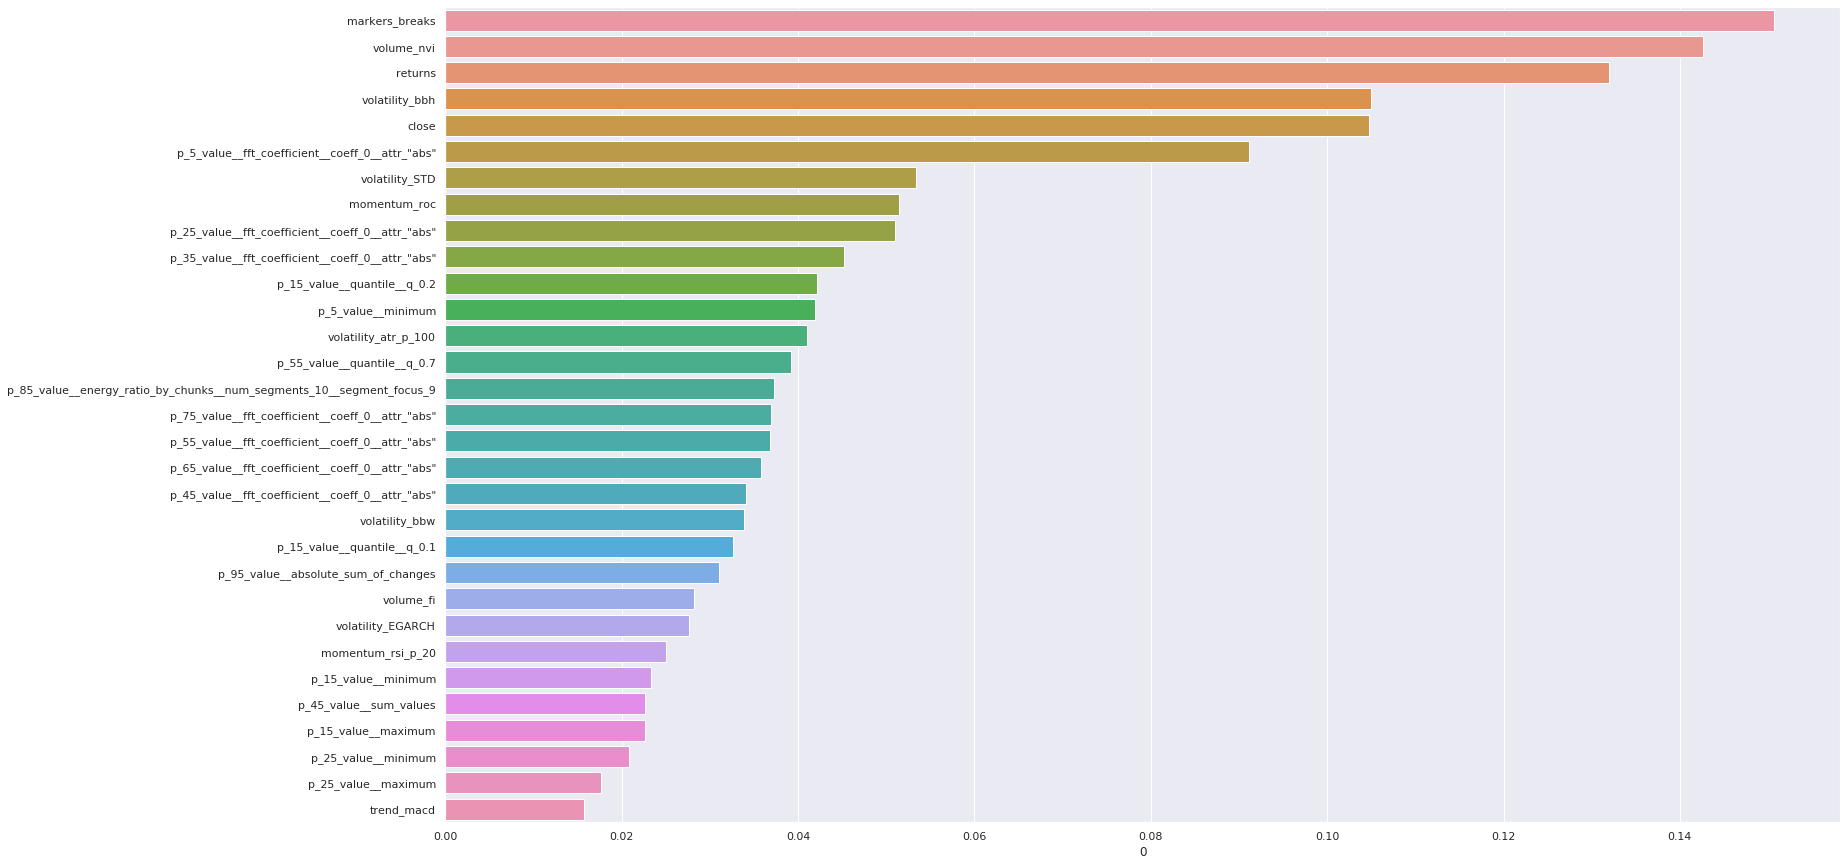

In [29]:
sns.mpl.rcParams['figure.figsize'] = (25.0, 15.0)
sns.barplot(x=dseries_feature, y=dseries_feature.index)

In [30]:
threshold = 0.08
dseries_feature[dseries_feature>threshold].index

Index(['markers_breaks', 'volume_nvi', 'returns', 'volatility_bbh', 'close',
       'p_5_value__fft_coefficient__coeff_0__attr_"abs"'],
      dtype='object')

## Снижение размерности

In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [31]:
# %%time
# X_embedded = TSNE(n_components=2).fit_transform(X)

In [32]:
%%time
X_PCA =PCA(n_components=2).fit_transform(X_scaled)
df_PCA = pd.DataFrame(data=X_PCA, columns = ['principal component 1', 'principal component 2'])

CPU times: user 5.58 s, sys: 255 ms, total: 5.84 s
Wall time: 986 ms


## Подбор количества компонент

In [33]:
# comp = []
# for i in tqdm(range(3,10)):
#     model = hmm.GaussianHMM(n_components=i, covariance_type="full", n_iter=100)
#     model.fit(X[ds_vlad_dep[ds_vlad_dep>0.015].index])
#     comp.append(round(model.score(X[ds_vlad_dep[ds_vlad_dep>0.015].index]), 0))

In [34]:
# df_comp = pd.DataFrame(comp)
# df_comp = df_comp.rename(columns={0:'Metrics'})

In [35]:
# sns.mpl.rcParams['figure.figsize'] = (25.0, 10.0)
# (df_comp*-1).plot()

# Окончание экспериментов

In [ ]:
#Отсюда

## Обучение модели

#### Разные варианты разделения

In [36]:
%%time
model = hmm.GaussianHMM(n_components=5, covariance_type="full", n_iter=100)
model.fit(df_X_scaled)
num_clasters_5 = model.predict(df_X_scaled)

CPU times: user 5min 58s, sys: 5.87 s, total: 6min 4s
Wall time: 4min 26s


## Оценка результатов

In [87]:
df_data[(df_data['datetime']>="2019-12-01") & (df_data['datetime'] < "2020-01-01")] 

,trend_macd_diff,p_35_value__quantile__q_0.2,p_5_volatility_atr,p_35_value__maximum,p_65_value__quantile__q_0.7,"p_155_value__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""",p_155_value__index_mass_quantile__q_0.9,p_35_value__quantile__q_0.7,"p_95_value__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","p_35_value__fft_coefficient__coeff_0__attr_""real""",...,p_5_momentum_rsi,"p_125_value__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""",momentum_roc,p_65_value__minimum,p_35_trend_trix,"p_65_value__fft_aggregated__aggtype_""kurtosis""",p_35_momentum_rsi,p_35_momentum_stoch,close,datetime
286646,-0.928250,-0.000061,5.509800,0.000134,0.000067,-1.623806e-06,0.845161,0.000053,-0.000224,0.000178,...,43.871546,-0.000232,0.112717,-0.000201,0.008969,22.700880,54.093763,47.457627,7549.5,2019-12-01 00:00:04.229841
286647,-1.087230,-0.000061,4.707840,0.000134,0.000067,-5.519022e-06,0.851613,0.000053,-0.000224,0.000111,...,41.208549,-0.000232,0.112732,-0.000201,0.008922,23.099014,53.769315,44.067797,7548.5,2019-12-01 00:00:09.063188
286648,-1.353878,-0.000061,4.366272,0.000134,0.000067,-1.535147e-06,0.845161,0.000053,-0.000224,0.000126,...,33.567715,-0.000232,0.019883,-0.000201,0.008852,23.813165,52.791464,33.898305,7545.5,2019-12-01 00:01:10.201847
286649,-1.798581,-0.000061,4.593018,0.000134,0.000067,6.423087e-07,0.851613,0.000030,-0.000224,-0.000007,...,24.214083,-0.000232,-0.165497,-0.000201,0.008751,24.754833,51.194129,16.949153,7540.5,2019-12-01 00:05:16.987738
286650,-2.199840,-0.000067,4.774414,0.000134,0.000067,-3.390981e-06,0.864516,0.000030,-0.000224,-0.000096,...,20.028403,-0.000225,-0.277833,-0.000201,0.008616,24.758685,50.254943,8.333333,7537.5,2019-12-01 00:06:42.848722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306780,-1.211295,-0.000039,2.844468,0.000126,0.000039,-9.141883e-06,0.864516,0.000038,-0.000150,0.000236,...,36.222491,-0.000128,-0.013958,-0.000126,0.003869,28.960024,53.736571,61.194030,7163.5,2019-12-31 23:42:19.629987
306781,-1.118889,-0.000033,2.975574,0.000126,0.000039,-8.105836e-06,0.864516,0.000038,-0.000150,0.000315,...,52.772721,-0.000128,-0.013951,-0.000126,0.004026,28.997836,55.253920,69.354839,7167.0,2019-12-31 23:48:15.200320
306782,-0.788015,-0.000033,3.180459,0.000126,0.000039,1.964758e-06,0.864516,0.000038,-0.000150,0.000244,...,65.545478,-0.000128,0.055811,-0.000126,0.004178,29.820339,56.916341,82.258065,7171.0,2019-12-31 23:51:25.784185
306783,-0.355133,-0.000033,3.444368,0.000126,0.000040,6.663188e-06,0.877419,0.000039,-0.000150,0.000307,...,73.410780,-0.000141,0.125602,-0.000126,0.004334,26.478399,58.311424,93.548387,7174.5,2019-12-31 23:53:42.967982


In [37]:
df_result = deepcopy(df_data_to_test)

In [38]:
df_result['num_clasters_5'] = num_clasters_5
#df_result['num_clasters_7'] = num_clasters_7

In [38]:
left_border = 286_646
right_border = 306_785

In [39]:
print(len(df_result))
print(df_result['num_clasters_5'][left_border:right_border].nunique())
print(df_result['num_clasters_7'][left_border:right_border].nunique())

325218
5
7


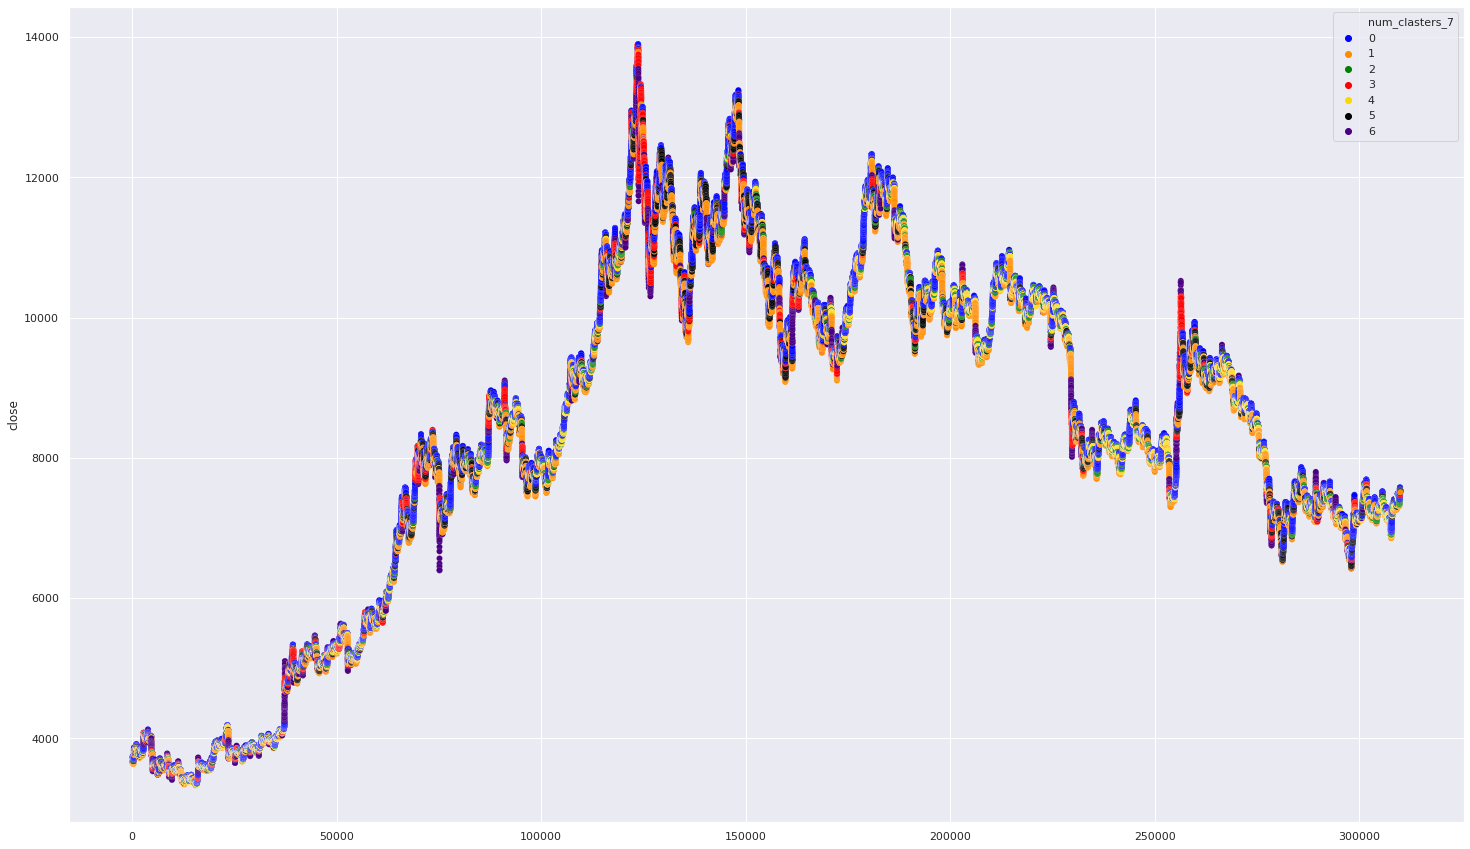

In [51]:
# Отсюда
#1 blue
#2 darkorange
#3 green
#4 red
#5 gold
#6 black
#7 indigo
#8 olive
#9 orchid
#10 grey


colors = ['blue',
          'darkorange',
          'green',
          'red',
          'gold',
          'black',
          'indigo'         
         ]

sns.scatterplot(x=df_result.iloc[0:310_000].index,
                y='close', 
                hue='num_clasters_7', 
                #aspect=1.7, 
                #height=10, 
                data=df_result.iloc[0:310_000], 
                palette=colors[:df_result.iloc[0:310_000]['num_clasters_7'].nunique()], 
                linewidth=0.1,
                #alpha=0.3
               )

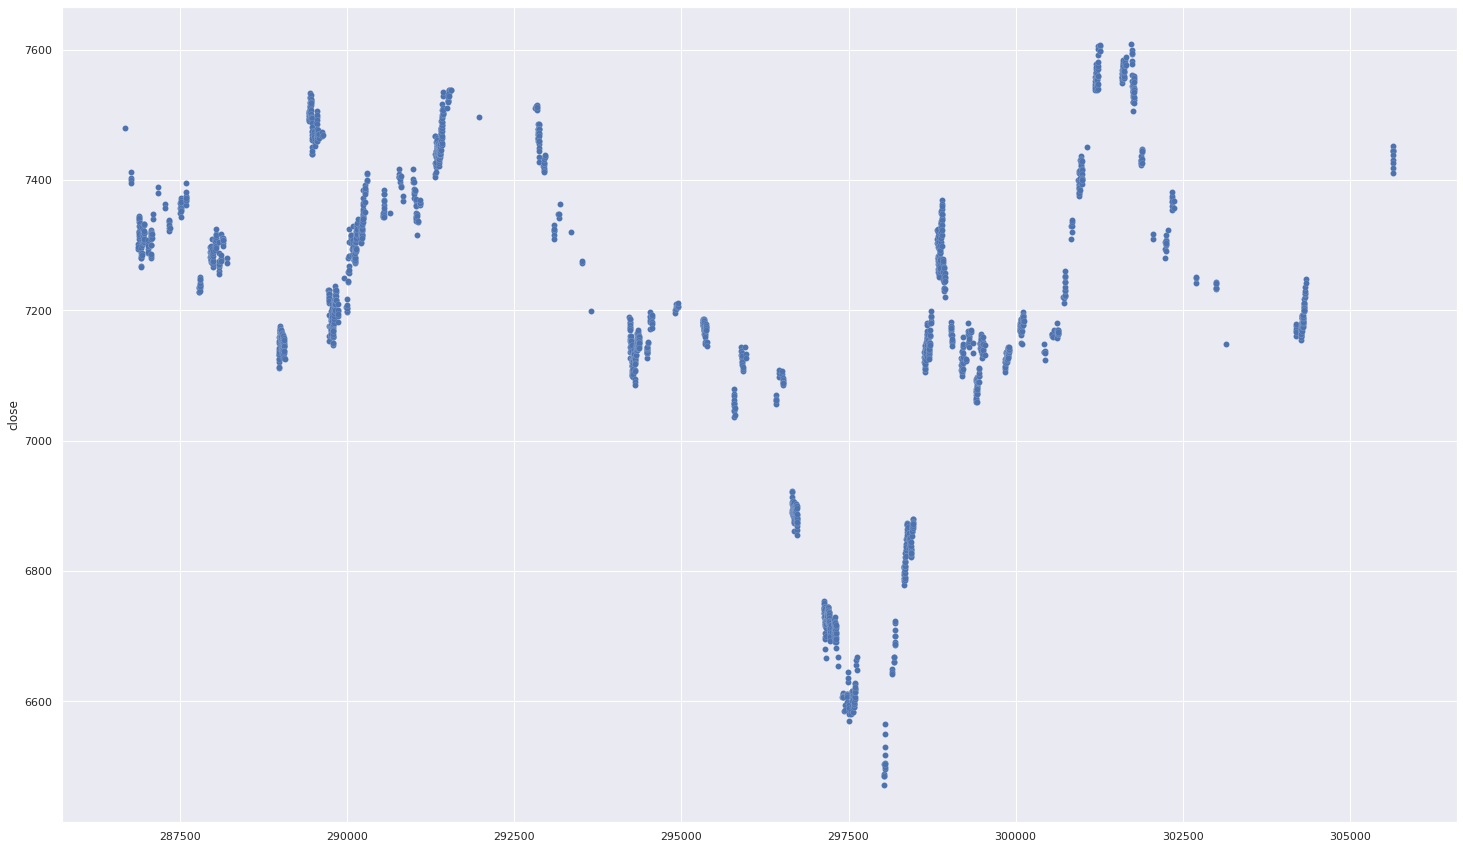

In [49]:
sns.scatterplot(x=df_result[df_result['num_clasters_5']==2].loc[286646:306785].index, 
                y='close',
                data=df_result[df_result['num_clasters_5']==2].loc[286646:306785], 
                linewidth=0.1
               )